# Metrics code

In [1]:
# Third-party libraries
import map_metric_api
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.utils.multiclass


def _sort_detection_by_confidence(detections):
    # We sort the detection by decreasing confidence
    sort_indices = np.argsort(detections[:, 1])[::-1]
    # sort_indices = np.arange(detections.shape[0])
    return detections[sort_indices, :]


def compute_mAP(ground_truths, detections, iou_threshold, match_algorithm='coco'):
    """mAP computation

    Args:
        ground_truths {list}    -- List of ground truths
        detections {list}       -- List of detections
        iou_threshold {float}   -- Threshold to use for IOU
        match_algorithm {str}   -- 'xview', 'non-unitary' or 'coco' to choose the matching algorithm

    Returns:
        {float} -- Computed mean average precision

    """
    map_computer = map_metric_api.MeanAveragePrecisionMetric(iou_threshold, match_algorithm, trim_invalid_geometry=True)
    map_computer.update(detections, ground_truths)
    mean_average_precision = map_computer.compute()
    map_computer.reset()
    return mean_average_precision


def compute_metrics(ground_truths, detections, iou_threshold, match_algorithm='coco'):
    """Compute metrics and format them in a dataframe

    Args:
        ground_truths {list}    -- List of ground truths
        detections {list}       -- List of detections
        iou_threshold {float}   -- Threshold to use for IOU
        match_algorithm {str}   -- 'xview', 'non-unitary' or 'coco' to choose the matching algorithm

    Returns:
        {pd.DataFrame} -- Dataframe with all metrics for the selected ground truths and predictions

    """
    # Compute metrics
    map_computer = map_metric_api.MeanAveragePrecisionMetric(iou_threshold, match_algorithm, trim_invalid_geometry=True)
    map_computer.update(detections, ground_truths)
    map_computer.compute()

    # Re-map metrics
    metrics_dict = {
        tag.lower(): [
            iou_threshold, map_computer.precision_per_class[tag], map_computer.recall_per_class[tag],
            map_computer.number_true_detection_per_class[tag], map_computer.number_false_detection_per_class[tag],
            map_computer.number_missed_ground_truth_per_class[tag], 0
        ]
        for tag in map_computer.precision_per_class.keys()
    }

    # Reset computer
    map_computer.reset()

    # Create dataframe
    columns = ['Threshold', 'Precision', 'Recall', 'TP', 'FP', 'FN', 'TN']
    return pd.DataFrame.from_dict(metrics_dict, orient='index', columns=columns).sort_index()


def compute_confusion_matrix(ground_truths, detections, iou_threshold, match_algorithm='coco'):
    """Compute confusion matrix.

    Args:
        ground_truths {list}    -- List of ground truths
        detections {list}       -- List of detections
        iou_threshold {float}   -- Threshold to use for IOU
        match_algorithm {str}   -- 'xview', 'non-unitary' or 'coco' to choose the matching algorithm

    Returns:
        {np.ndarray} -- Dataframe with all metrics for the selected ground truths and predictions

    """
    # Init engine
    match_engine = map_metric_api.match_detections.MatchEngineIoU(iou_threshold, match_algorithm)

    # Convert to map metric format
    _, gt_array = map_metric_api.utils.geometry_utils.get_type_and_convert(ground_truths, trim_invalid_geometry=True)
    _, detec_array = map_metric_api.utils.geometry_utils.get_type_and_convert(detections, trim_invalid_geometry=True)

    # Sort detections by confidence
    # FIXME: detections are sorted twice in detection scoring library
    detec_array_2 = _sort_detection_by_confidence(detec_array)
    detec_array_3 = _sort_detection_by_confidence(detec_array_2)

    # Match ground truths with detections
    match_matrix = match_engine.match(detec_array[:, :2], gt_array[:, :1])

    # Compute the detected ground truth (without classif) and detection
    left_match = match_matrix.sum(axis=1)
    right_match = match_matrix.sum(axis=0)

    # Compute confusion matrix
    y_true, y_pred = [], []

    for i, j in zip(*np.where(match_matrix == 1)):
        y_true.append(gt_array[j][1])
        y_pred.append(detec_array_3[i][2])
    for i in np.where(left_match == 0)[0]:
        y_true.append('')
        y_pred.append(detec_array_3[i][2])
    for j in np.where(right_match == 0)[0]:
        y_true.append(gt_array[j][1])
        y_pred.append('')

    # Labels to use
    labels = sklearn.utils.multiclass.unique_labels(y_true, y_pred)

    # Compute confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels)

    # Put it in a dataframe
    confusion_matrix_df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

    # Plot heatmap
    return confusion_matrix, confusion_matrix_df, labels


# Read data

In [65]:
# Standard libraries
import json
import pathlib

# Third-party libraries
import geojson



# Variables
predictions_folder = './data/qualif_earthcube/predictions'
maritime_folder = './data/qualif_earthcube/maritime'
isahit_folder = './data/qualif_earthcube/isahit'
geo4i_folder = './data/qualif_earthcube/geo4I'


def get_taxonomy(folder):
    taxonomy_file = pathlib.Path(folder) / 'taxonomy.json'
    assert taxonomy_file.exists()
    
    with open(taxonomy_file) as file:
        content = json.load(file)
        # Filter added tags
        content.pop('added tags')
        
    return content


class Dataset(object):
    
    def __init__(self, dataset_folder, is_ground_truth=True):

        # Check file
        dataset_file = pathlib.Path(dataset_folder) / 'dataset.json'
        assert dataset_file.exists()
        
        # Extract zones
        self.zones = self.extract_zones(dataset_file, is_ground_truth=is_ground_truth)
                
    @staticmethod
    def extract_zones(dataset_file, is_ground_truth=True):

        def filter_tags(tags):
            if 'merchant_vessel' in tags or 'vessel-merchant' in tags:
                return 'merchant_vessel'
            elif 'barge' in tags:
                return 'barge'
            elif 'speed_vessel' in tags or 'vessel-vedette' in tags:
                return 'speed_vessel'
            elif 'support_vessel' in tags or 'vessel-support' in tags:
                return 'support_vessel'
            elif 'civilian_vessel' in tags or 'leisure_vessel' in tags or 'fishing_vessel' in tags or 'passenger_vessel' in tags or 'vessel-civilian' in tags:
                return 'civilian_vessel'
            elif 'marina' in tags:
                return 'marina'
            elif 'submarine' in tags or 'vessel-submarine' in tags:
                return 'submarine'
            elif 'military_vessel' in tags or 'aircraft_carrier' in tags or 'vessel-warship' in tags:
                return 'military_vessel'
            elif 'unclassified' in tags or 'ship' in tags:
                return 'unclassified'

            return 'unknown'
            
        
        def map_records(features):
            mapped_records = []
            for feature in features:
                tag = filter_tags(feature.properties['tags'])
                if is_ground_truth is False:
                    mapped_records.append((feature.geometry.coordinates, 1.0, tag))
                else:
                    mapped_records.append((feature.geometry.coordinates, tag))
                    
            return mapped_records

        zones = []
        with open(dataset_file) as file:
            feature_collection = geojson.load(file)
            for feature in feature_collection.features:
                zone = {
                    'geometry': feature.geometry,
                    'properties': feature.properties,
                    'records': map_records(feature.records.features) if 'records' in feature else []
                }
                zones.append(zone)
        
        return zones
    
    @property
    def zone_names(self):
        return list(map(lambda zone: zone['properties']['name'], self.zones))
                


taxonomy = get_taxonomy(predictions_folder)
print(taxonomy)

prediction_dataset = Dataset(predictions_folder, is_ground_truth=False)
maritime_dataset = Dataset(maritime_folder, is_ground_truth=True)
isahit_dataset = Dataset(isahit_folder, is_ground_truth=True)
geo4i_dataset = Dataset(geo4i_folder, is_ground_truth=True)

print(f'Predictions: {len(prediction_dataset.zones)} zones')
print(f'Maritime   : {len(maritime_dataset.zones)} zones')
print(f'Isahit     : {len(isahit_dataset.zones)} zones')
print(f'Geo4I      : {len(geo4i_dataset.zones)} zones')

{'ship': {'civilian_vessel': {'leisure_vessel': None, 'fishing_vessel': None, 'passenger_vessel': None}, 'military_vessel': {'aircraft_carrier': None, 'submarine': None}, 'merchant_vessel': None, 'unclassified': None, 'support_vessel': None, 'speed_vessel': None, 'barge': None}, 'marina': None, 'unknown': None}
Predictions: 25 zones
Maritime   : 9 zones
Isahit     : 9 zones
Geo4I      : 15 zones


In [15]:
prediction_dataset.zone_names

['job_2020-09-21_1. Rotterdam EC Ships',
 'job_2020-09-23_2. EMSA Baltic Sea EC Ships',
 'job_2020-09-24_1. Madagascar EC Ships',
 'job_2020-09-30_Algers 1 - Ships Detection',
 'job_2020-09-30_Naval Base Kowait EC Ships',
 'job_2020-09-30_Naval Amphibious Base Little Creek EC Ships',
 'job_2020-09-30_Naval Base San Diego EC Ships',
 'job_2020-10-01_Naval Base Point Loma EC Ships',
 'job_2020-10-01_Naval Base Pearl Harbour EC Ships',
 'job_2020-10-01_Naval Station Norfolk EC Ships',
 'job_2020-10-06_Coast Guard Sector Puget Sound EC Ships',
 'job_2020-10-06_4. NC Kea Trader EC Ships',
 'job_2020-10-06_Coast Guard Sector Hampton Roads EC Ships',
 'job_2020-10-12_5. Qatar Demo PHR EC Ship',
 'job_2020-10-29_6. Pohnpei Micronesie EC Ships',
 'job_2020-11-01_8. Algalega EC Ships',
 'job_2020-11-03_7. Hambourg EC Ships',
 'job_2020-11-16_8. Alexandrie EC Ships',
 'job_2020-11-08_5. Tokyo EC Ships',
 'job_2020-11-11_7. Dubai EC Ships',
 'job_2020-11-16_6. Santos EC Ships',
 'job_2020-11-04_2.

In [16]:
maritime_dataset.zone_names

['6. Port de Santos, Brazil',
 '7. Dubai Port (Big)',
 '9. Singapore (clouds)',
 '1. Rotterdam',
 '2. Shanghai International Port',
 '3. Busan Port (Big)',
 '4. Houston harbor (clouds)',
 '5. Tokyo Port',
 '8. Alexandrie Port']

In [17]:
isahit_dataset.zone_names

['13. SLN Palkstrait | SPOT6 | 2017-04-26',
 '26. FAA ATL Royal | SPOT7 | 2017-08-29',
 '2. Emsa Baltic Sea | PHR1A | 2017-07-17',
 '6. Pohnpei, Micronesie | PHR1B | 2017-06-10',
 '7. Hambourg | PHR1B | 2017-07-06',
 '1. Madagascar Nord | PHR1A | 2016-04-29',
 '5. Qatar Demo | PHR1B | 2017-05-04',
 '4. NC Kea Trader | PHR1A | 2018-02-23',
 '8. Algalega | PHR1B | 2017-12-18']

In [18]:
geo4i_dataset.zone_names

['job_2019-08-23_Naval Support Facility Diego Garcia',
 'job_2019-08-23_Naval Base Pearl Harbor',
 'job_2019-09-30_Yokosuka | PHR 1B',
 'job_2019-08-23_Naval Base Kowait | PHR1A',
 'job_2019-08-23_Coast guard Sector Hampton Roads | PHR1B',
 'job_2019-08-23_Naval Amphibious Base Little Creek | PHR1B',
 'job_2019-08-23_Naval Amphibious Base Little Creek | SPOT6',
 'job_2019-08-23_Naval Station Norfolk | PHR1B',
 'job_2019-09-30_US Navy Sasebo',
 'job_2019-08-23_Naval Base San Diego | PHR1B',
 'job_2019-08-23_Naval Base Guam | PHR1B',
 'job_2019-08-23_Coast Guard Sector Puget Sound | PHR1A',
 'job_2019-08-23_Naval Base Point Loma | PHR1B',
 'job_2019-09-30_US Navy Sasebo',
 'job_2019-09-30_Gunwharf quays | PHR1B']

## Mapping

In [66]:
zone_mapping = {
    '1 - Rotterdam': (prediction_dataset.zones[0], maritime_dataset.zones[3]),
    '2 - EMSA Baltic Sea | PHR1A': (prediction_dataset.zones[1], isahit_dataset.zones[2]),
    '1 - Madagascar Nord | PHR1A': (prediction_dataset.zones[2], isahit_dataset.zones[5]),
    'Naval Base Kowait': (prediction_dataset.zones[4], geo4i_dataset.zones[3]),
    'Naval Amphibious Base Little Creek | PHR1B': (prediction_dataset.zones[5], geo4i_dataset.zones[5]),
    'Naval Amphibious Base Little Creek | SPOT6': (prediction_dataset.zones[5], geo4i_dataset.zones[6]),
    'Naval Base San Diego | PHR1B': (prediction_dataset.zones[6], geo4i_dataset.zones[9]),
    'Naval Base Point Loma | PHR1B': (prediction_dataset.zones[7], geo4i_dataset.zones[12]),
    'Naval Base Pearl Harbour': (prediction_dataset.zones[8], geo4i_dataset.zones[1]),
    'Naval Station Norfolk | PHR1B': (prediction_dataset.zones[9], geo4i_dataset.zones[7]),
    'Coast Guard Sector Puget Sound | PHR1A': (prediction_dataset.zones[10], geo4i_dataset.zones[11]),
    '4. NC Kea Trader | PHR1A': (prediction_dataset.zones[11], isahit_dataset.zones[7]),
    'Coast Guard Sector Hampton Roads | PHR1B': (prediction_dataset.zones[12], geo4i_dataset.zones[4]),
    '5. Qatar Demo | PHR1B': (prediction_dataset.zones[13], isahit_dataset.zones[6]),
    '6. Pohnpei Micronesie | PHR1B': (prediction_dataset.zones[14], isahit_dataset.zones[3]),
    '8. Algalega | PHR1B': (prediction_dataset.zones[15], isahit_dataset.zones[8]),
    '7. Hambourg | PHR1B': (prediction_dataset.zones[16], isahit_dataset.zones[4]),
    '8. Alexandrie Port': (prediction_dataset.zones[17], maritime_dataset.zones[8]),
    '5. Tokyo Port': (prediction_dataset.zones[18], maritime_dataset.zones[7]),
    '7. Dubai Port': (prediction_dataset.zones[19], maritime_dataset.zones[1]),
    '6. Port de Santos, Brazil': (prediction_dataset.zones[20], maritime_dataset.zones[0]),
    '2. Shanghai International Port': (prediction_dataset.zones[21], maritime_dataset.zones[4]),
    '4. Houston harbor (clouds)': (prediction_dataset.zones[22], maritime_dataset.zones[6]),
    '9. Singapore (clouds)': (prediction_dataset.zones[23], maritime_dataset.zones[2]),
    'Gunwharf quays | PHR1B': (prediction_dataset.zones[24], geo4i_dataset.zones[14]),
}

### 1 - Rotterdam

In [77]:
import seaborn as sns


# Zones
pred_zone, gt_zone = zone_mapping['9. Singapore (clouds)']

print(f"Predictions : {len(pred_zone['records'])}")
print(f"Ground truth: {len(gt_zone['records'])}")

# Confusion matrix
cm, cm_df, labels = compute_confusion_matrix(
    gt_zone['records'],
    pred_zone['records'],
    0.000001,
    match_algorithm='non-unitary'
)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

Predictions : 2173
Ground truth: 0


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [70]:
cm_df

,,barge,civilian_vessel,marina,merchant_vessel,military_vessel,speed_vessel,submarine,support_vessel,unclassified
,0,250,1680,0,33,23,1,9,0,0
barge,0,0,0,0,0,0,0,0,0,0
civilian_vessel,2,0,2,0,0,0,0,0,0,0
marina,4,120,1083,0,25,4,0,0,0,0
merchant_vessel,3,2,3,0,6,0,0,0,0,0
military_vessel,0,0,0,0,0,0,0,0,0,0
speed_vessel,2,0,1,0,0,0,0,0,0,0
submarine,0,0,0,0,0,0,0,0,0,0
support_vessel,0,0,2,0,0,0,0,0,0,0
unclassified,88,70,324,0,89,17,0,2,0,0


# Total matrix

Predictions : 23066
Ground truth: 8768


/Users/AlexandreMayerowitz/miniconda3/envs/dlcooker/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['' 'barge' 'civilian_vessel' 'marina' 'merchant_vessel' 'military_vessel'
 'speed_vessel' 'submarine' 'support_vessel' 'unclassified'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


<AxesSubplot:>

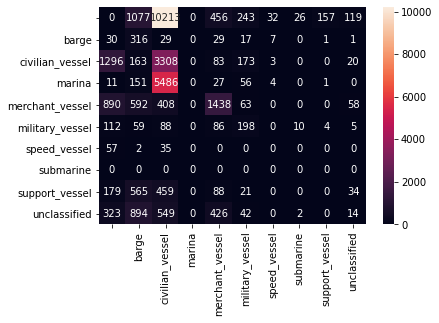

In [75]:
preds_zone_records = []
gts_zone_records = []
for key, (pred_zone, gt_zone) in zone_mapping.items():
    if key != 'Naval Amphibious Base Little Creek | SPOT6':
        preds_zone_records.extend(pred_zone['records'])
        gts_zone_records.extend(gt_zone['records'])
    

print(f"Predictions : {len(preds_zone_records)}")
print(f"Ground truth: {len(gts_zone_records)}")

# Confusion matrix
cm, cm_df, labels = compute_confusion_matrix(
    gts_zone_records,
    preds_zone_records,
    0.000001,
    match_algorithm='non-unitary'
)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

In [76]:
cm_df

,,barge,civilian_vessel,marina,merchant_vessel,military_vessel,speed_vessel,submarine,support_vessel,unclassified
,0,1077,10213,0,456,243,32,26,157,119
barge,30,316,29,0,29,17,7,0,1,1
civilian_vessel,1296,163,3308,0,83,173,3,0,0,20
marina,11,151,5486,0,27,56,4,0,1,0
merchant_vessel,890,592,408,0,1438,63,0,0,0,58
military_vessel,112,59,88,0,86,198,0,10,4,5
speed_vessel,57,2,35,0,0,0,0,0,0,0
submarine,0,0,0,0,0,0,0,0,0,0
support_vessel,179,565,459,0,88,21,0,0,0,34
unclassified,323,894,549,0,426,42,0,2,0,14


In [ ]:
from test import compute_confusion_matrix

# Variables
ground_truths = [
    ([[[0, 0], [0, 1], [1, 1], [1, 0], [0, 0]]], 'building'),
    ([[[1, 1], [1, 2], [2, 2], [2, 1], [1, 1]]], 'road')
] 
detections = [
    ([[[0, 0], [0, 1], [1, 1], [1, 0], [0, 0]]], 1.0, 'building'),
    ([[[3, 3], [3, 4], [4, 4], [4, 3], [3, 3]]], 1.0, 'vegetation')
]

cm, cm_df, labels = compute_confusion_matrix(ground_truths, detections, 0.5)

In [ ]:
import seaborn as sns


sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)